In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import requests
import pylab
%pylab inline
import pandas as pd
import re
from collections import defaultdict
PRINT_H = False

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# input data
df = pd.read_csv("pima-extract.csv", sep="|").fillna('')
# REMOVE entries with ipv6
df2 = df[df['ip.src']!=''][['frame.time_relative', 'ip.src', 'dns.qry.name']]
df2.head()

,frame.time_relative,ip.src,dns.qry.name
0,0.000000,24.9.76.250,android.clients.google.com
1,0.000001,69.241.95.82,e3645.b.akamaiedge.net
2,0.000005,24.9.76.250,android.clients.google.com
3,0.000009,24.9.76.250,android.clients.google.com
4,0.000010,73.153.66.183,www.polls.newsvine.com


In [3]:
# window by time function
def window_df(df, win):
    '''returns a list of windowed dataframes given original df and window value (in time seconds)'''
    windowed = []
    MAX_T = round( df.iloc[-1]['frame.time_relative'] )
    for t in np.arange(0, MAX_T, win):
        df_win = df [ (df['frame.time_relative'] >= t) & (df['frame.time_relative'] < (t+win)) ]
        windowed.append(df_win)
    return windowed

In [4]:
# TEST
list_wind = window_df( df2, 10 )
print len(list_wind)
print len(list_wind[5])
#list_wind[5]

6
346794


In [5]:
# split by srcip - each home is a separate tree of DNS
# can't have common root as same node name will create a graph instead of a tree
def dns_per_src(df):
    '''input df[time, src, dns] output dict{ src: [dns] }'''
    grp = df.groupby('ip.src')
    dict_of_domains = grp['dns.qry.name'].aggregate(lambda x: list(set(x))).to_dict()
    return dict_of_domains

In [6]:
# TEST
dns_per_src(df2.head(30))

{'107.2.42.58': ['profile.ess.apple.com'],
 '24.9.76.250': ['android.clients.google.com'],
 '50.134.220.221': ['teredo.ipv6.microsoft.com'],
 '50.170.152.251': ['t.appsflyer.com'],
 '50.183.21.69': ['p04-imap.mail.me.com.akadns.net'],
 '50.183.81.160': ['lucy.corp.netopia.com'],
 '67.190.144.191': ['sync.syngenta.com'],
 '69.241.95.82': ['e3645.b.akamaiedge.net'],
 '69.241.95.86': ['dsn2.skype-dsn.akadns.net'],
 '69.244.58.56': ['tvxlgp-br-c494.lp.xcal.tv'],
 '69.252.212.70': ['_ldap._tcp.pdc._msdcs.mii.com'],
 '69.252.212.82': ['e.5.0.b.8.a.e.f.f.f.a.b.6.7.6.6.7.8.9.2.0.0.0.4.0.8.2.0.1.0.6.2.ip6.arpa'],
 '71.56.196.188': ['secure.insightexpressai.com'],
 '73.14.136.124': ['wpad.corp.intranet'],
 '73.153.66.183': ['www.polls.newsvine.com'],
 '73.24.236.171': ['go.aniview.com',
  'lb-adselect-344315156.us-west-2.elb.amazonaws.com'],
 '73.34.159.53': ['content.tegna-media.com'],
 '73.34.180.29': ['www.telegraph.co.uk'],
 '73.34.207.26': ['_ldap._tcp.pdc._msdcs.mii.com'],
 '73.78.52.192':

In [7]:
def split_domain(domain):
    '''input domain return split domain at find every "." 
    eg: cs.princeton.edu -> ['cs.princeton.edu', 'princeton.edu', 'edu']
    then reverse it before adding it to tree'''
    
    node_list = [domain]
    for m in re.finditer('\.', domain):
        # TODO: add a way to neglect IP addresses and single characters from splitting
        node_list.append( domain[m.end():] )
    
    node_list.reverse()
    
    return node_list

In [8]:
# TEST
dom = 'cs.princeton.edu'
split_domain(dom)

['edu', 'princeton.edu', 'cs.princeton.edu']

In [9]:
def add_branch(srcip, list_of_dns=[]):
    '''create a new tree graph for every home IP and dns list
    return the tree G'''
    # root is srcip
    G = nx.Graph()
    G.add_node(srcip)
    
    # empty tree
    if len(list_of_dns) == 0:
        return G
    
    # domain split using str.split('.')
    for domain in list_of_dns:
        dom_list = split_domain(domain)
        
        # connect to root (srcip) node
        if not G.has_edge(srcip, dom_list[0]):
            G.add_edge(srcip, dom_list[0])
            if PRINT_H: print "\t", srcip, "-->", dom_list[0]
        
        # rest of the domain nodes as branch using add_path
        G.add_path(dom_list)
        if PRINT_H: print "\t\t", dom_list
        
        # add list of split domains to a branch in tree
        #for i in range(len(dom_list)-1):
        #    if not G.has_node(dom_list[i]):
        #        G.add_node(dom_list[i])
        #    if not G.has_node(dom_list[i+1]):
        #        G.add_node(dom_list[i+1])
        #    if not G.has_edge(dom_list[i], dom_list[i+1]):
        #        G.add_edge(dom_list[i], dom_list[i+1])
        #        if PRINT_H: print "\t\t", dom_list[i], "-->", dom_list[i+1]
    return G

In [10]:
# TEST
G = add_branch('1.2.3.4', ['wpad.corp.intranet','lucy.corp.netopia.com', 'android.clients.google.com', 'www.google.com' ])

print G.nodes()

print G.edges()

['clients.google.com', 'wpad.corp.intranet', 'android.clients.google.com', 'netopia.com', '1.2.3.4', 'google.com', 'www.google.com', 'corp.intranet', 'corp.netopia.com', 'intranet', 'com', 'lucy.corp.netopia.com']
[('clients.google.com', 'android.clients.google.com'), ('clients.google.com', 'google.com'), ('wpad.corp.intranet', 'corp.intranet'), ('netopia.com', 'corp.netopia.com'), ('netopia.com', 'com'), ('1.2.3.4', 'intranet'), ('1.2.3.4', 'com'), ('google.com', 'com'), ('google.com', 'www.google.com'), ('corp.intranet', 'intranet'), ('corp.netopia.com', 'lucy.corp.netopia.com')]


In [11]:
def draw_domain_tree(G, srcip=''):
    '''input graph - plot it - unfortunately node positions are random or circular creating ugly graphs
    takes way too long for any df with 1k entries or above
    best to replace drawing method with ete3.Tree instead'''
    # print graph
    G2 = nx.Graph(nx.prim_mst_edges(G))
    #pos=nx.spring_layout(G2)
    #nx.set_node_attributes(G2,'pos',pos)
    
    plt.figure()
    if srcip!='':
        T = nx.bfs_tree(G2, srcip)
        nx.draw(T, with_labels=True)
    else:
        nx.draw(G2, with_labels=True)
    plt.show()
    return

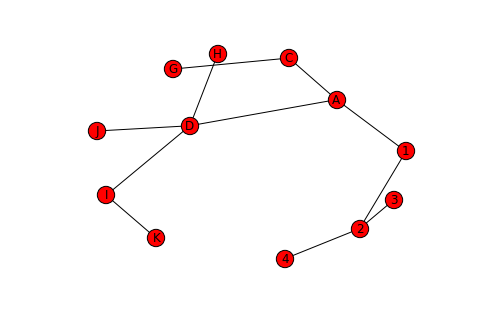

In [12]:
#TEST 1
G = nx.Graph()
G.add_node('A')
G.add_node('B')
G.add_node('C')
G.add_node('D')
G.add_node('E')
G.add_node('F')
G.add_node('G')
G.add_node('H')
G.add_node('I')
G.add_node('J')
G.add_node('K')
G.add_node('A')

G.add_edge('A', 'B')
G.add_edge('A', 'B')
G.add_edge('A', 'C')
G.add_edge('A', 'D')
G.add_edge('B', 'E')
G.add_edge('B', 'F')
G.add_edge('C', 'G')
G.add_edge('D', 'H')
G.add_edge('D', 'I')
G.add_edge('D', 'J')
G.add_edge('I', 'K')

G.add_path(['A', 1, 2, 3])
G.add_path([2, 4])
G.remove_node('B')
draw_domain_tree(G)

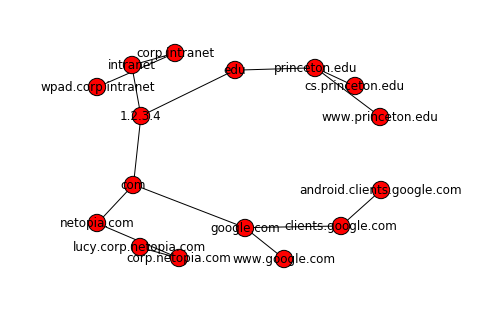

In [13]:
# TEST 2
G = add_branch('1.2.3.4', ['wpad.corp.intranet','lucy.corp.netopia.com', 'android.clients.google.com',
                           'www.google.com', 'cs.princeton.edu', 'www.princeton.edu' ])
draw_domain_tree(G)

In [14]:
def create_domain_tree(df):
    '''input dataframe of [time, srcip, dns]
    output dict of trees with root node as their source IPs'''
    
    root_tree = defaultdict(int)
    
    # 1. get dns list per source ip
    src_domain_dict = dns_per_src(df)
    
    # 2. for every srcip, add it to tree and add its branch to tree
    for srcip, domain_list in src_domain_dict.iteritems():
        root_tree[srcip] = add_branch(srcip, domain_list)

    return root_tree

In [15]:
# TEST
test_df = df2.head(30)
root_tree = create_domain_tree(test_df)
root_tree
#draw_domain_tree(G)

defaultdict(int,
            {'107.2.42.58': <networkx.classes.graph.Graph at 0x10e43ddd0>,
             '24.9.76.250': <networkx.classes.graph.Graph at 0x10e47db50>,
             '50.134.220.221': <networkx.classes.graph.Graph at 0x121c73a50>,
             '50.170.152.251': <networkx.classes.graph.Graph at 0x121c73f90>,
             '50.183.21.69': <networkx.classes.graph.Graph at 0x121c73f50>,
             '50.183.81.160': <networkx.classes.graph.Graph at 0x10e43df50>,
             '67.190.144.191': <networkx.classes.graph.Graph at 0x121c73c90>,
             '69.241.95.82': <networkx.classes.graph.Graph at 0x10e450690>,
             '69.241.95.86': <networkx.classes.graph.Graph at 0x10e4506d0>,
             '69.244.58.56': <networkx.classes.graph.Graph at 0x10e43df90>,
             '69.252.212.70': <networkx.classes.graph.Graph at 0x121c735d0>,
             '69.252.212.82': <networkx.classes.graph.Graph at 0x121c73e10>,
             '71.56.196.188': <networkx.classes.graph.Graph at 0

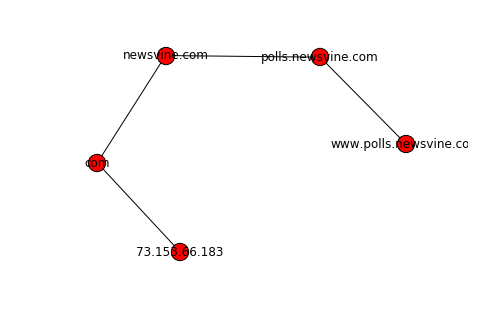

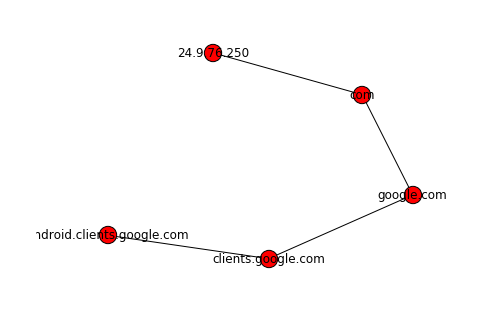

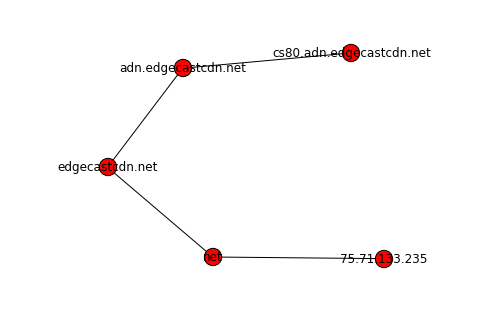

In [16]:
draw_domain_tree ( root_tree.values()[0] )
draw_domain_tree ( root_tree.values()[1] )
draw_domain_tree ( root_tree.values()[10] )

## TODO
- might need to replace networkx with ete3 Tree for better layout
- http://etetoolkit.org/

# Window every 5 sec

In [17]:
windowed = window_df(df2, 5.0)
print len(windowed)

12


In [18]:
root_tree = create_domain_tree(windowed[0])

['video.fsnc1-1.fna.fbcdn.net', '50.170.149.120', 'fbcdn.net', 'external.fsnc1-1.fna.fbcdn.net', 'fna.fbcdn.net', 'net', 'fsnc1-1.fna.fbcdn.net']
[('video.fsnc1-1.fna.fbcdn.net', 'fsnc1-1.fna.fbcdn.net'), ('50.170.149.120', 'net'), ('fbcdn.net', 'fna.fbcdn.net'), ('fbcdn.net', 'net'), ('external.fsnc1-1.fna.fbcdn.net', 'fsnc1-1.fna.fbcdn.net'), ('fna.fbcdn.net', 'fsnc1-1.fna.fbcdn.net')]


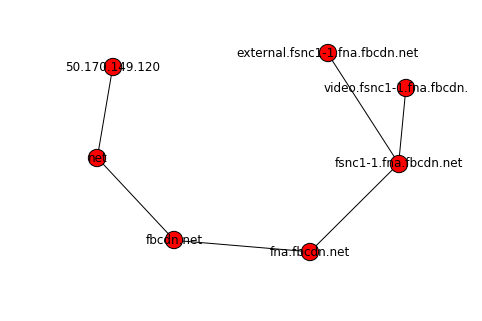

In [19]:
G1 = root_tree.values()[0]
print G1.nodes()
print G1.edges()
draw_domain_tree(G1)
# G1.remove_node('com')

# View of homes with IoTs (known)
- load known iot dns homes from processes/dns_iot_device_ipv4.pkl (saved using DNS-pima-quick-view.ipynb)

In [20]:
dns_iot_device = pd.read_pickle('processed/df_iot_device_ipv4.pkl')
dns_iot_device.head()

,frame.time_relative,eth.src,eth.dst,ip.src,ip.dst,dns.qry.name,device
156,0.425989,00:1f:a0:11:b5:3a,40:a8:f0:34:48:5c,173.14.26.110,69.252.212.80,fus01.ps4.update.playstation.net,ps
169,0.426302,00:1f:a0:11:b5:3a,40:a8:f0:34:1f:e0,71.229.198.23,69.252.212.84,log-rts11-iad01.devices.nest.com,nest_therm
290,0.428878,00:1f:a0:11:b5:3a,40:a8:f0:34:48:5c,69.244.12.6,69.252.212.78,www.meethue.com,hue
369,0.430517,00:1f:a0:11:b5:3a,40:a8:f0:33:fa:68,24.9.133.179,69.252.212.74,www.sharxsecurity.com,sharx
822,0.441398,00:1f:a0:11:b5:3a,40:a8:f0:34:48:5c,67.177.225.0,69.252.212.78,licensing.xboxlive.com,xbox


In [21]:
# TEST using just 10 IP addresses

# filter nest as example
nest_ips = dns_iot_device[dns_iot_device.device == 'nest_therm']['ip.src'].unique()

nest_ips_test=nest_ips[:10]

In [22]:
# extract known nest therm related IPs from windowed root trees
# each nest_window is dict {nest_ip: [tree_window1, tree_window2, ... ]}
nest_window = defaultdict(list)

for window_df in windowed:
    
    filtered_df = window_df[ window_df['ip.src'].isin( nest_ips_test ) ]
    
    # for 5 sec window all srcip that had any communication to nest and their complete dns trees
    nest_root_tree_dict = create_domain_tree( filtered_df )
    
    # rearrange as dict {nest_ip: [tree_window1, tree_window2, ... ]}
    for nest_ip, nest_tree in nest_root_tree_dict.iteritems():
        nest_window[nest_ip].append( nest_tree )

In [23]:
nest_window

defaultdict(list,
            {'174.51.73.184': [<networkx.classes.graph.Graph at 0x118fde850>],
             '67.190.48.202': [<networkx.classes.graph.Graph at 0x118fe2ad0>],
             '69.241.95.82': [<networkx.classes.graph.Graph at 0x118fe2e10>,
             '69.241.95.83': [<networkx.classes.graph.Graph at 0x116975e50>,
             '69.241.95.84': [<networkx.classes.graph.Graph at 0x117c74090>,
             '69.241.95.86': [<networkx.classes.graph.Graph at 0x11aa01fd0>,
             '70.90.112.54': [<networkx.classes.graph.Graph at 0x118fe23d0>,
             '71.229.148.200': [<networkx.classes.graph.Graph at 0x13e37ffd0>],
             '71.229.198.23': [<networkx.classes.graph.Graph at 0x13df41fd0>,
             '73.95.47.13': [<networkx.classes.graph.Graph at 0x118fe29d0>,
              <networkx.classes.graph.Graph at 0x14acc9d90>]})



1 IP:  174.51.73.184 number of windows:  1
Total nodes: 5 Total edges:  4 Out degree at depth 1:  1
contains nest.com?  True


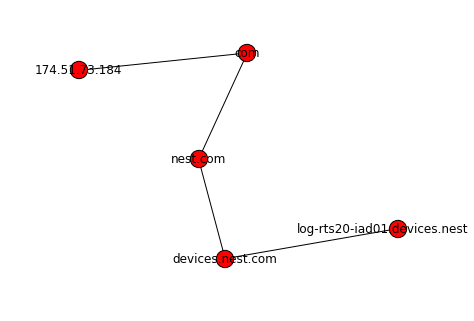



2 IP:  73.95.47.13 number of windows:  2
Total nodes: 9 Total edges:  8 Out degree at depth 1:  1
contains nest.com?  True


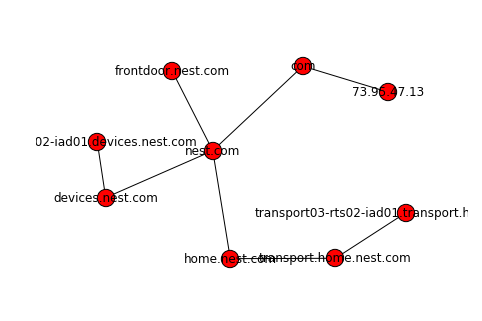

Total nodes: 5 Total edges:  4 Out degree at depth 1:  1
contains nest.com?  False


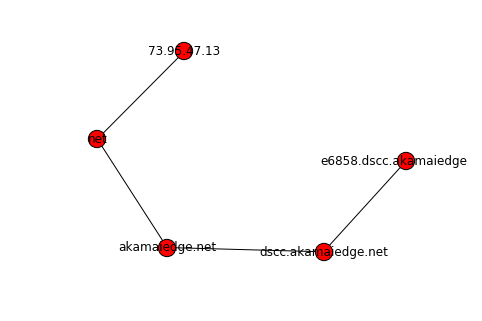



3 IP:  70.90.112.54 number of windows:  8
Total nodes: 5 Total edges:  4 Out degree at depth 1:  1
contains nest.com?  True


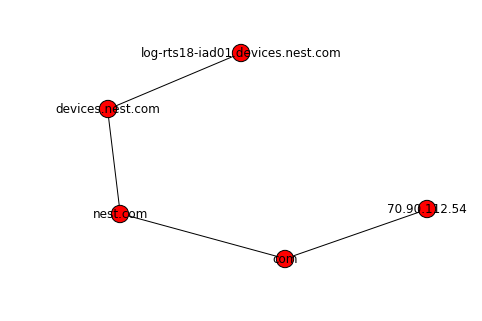

Total nodes: 5 Total edges:  4 Out degree at depth 1:  1
contains nest.com?  True


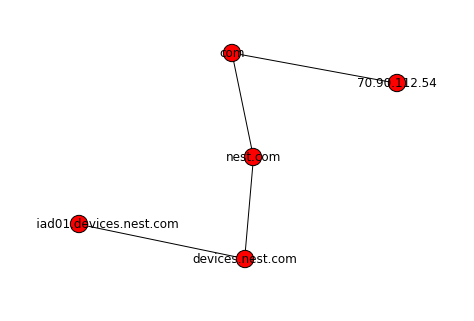

Total nodes: 5 Total edges:  4 Out degree at depth 1:  1
contains nest.com?  True


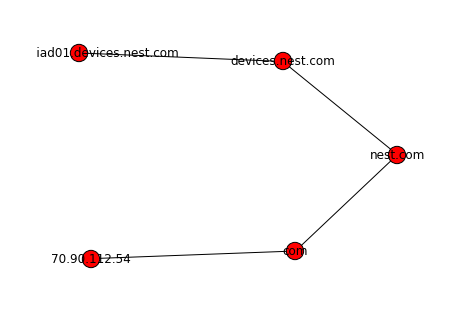

Total nodes: 5 Total edges:  4 Out degree at depth 1:  1
contains nest.com?  True


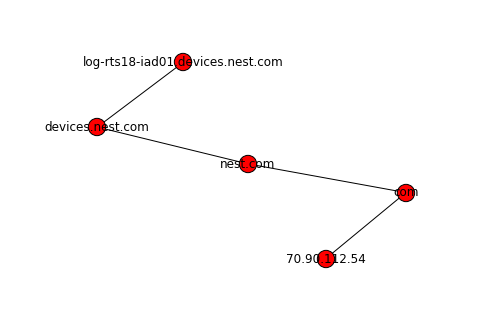

Total nodes: 5 Total edges:  4 Out degree at depth 1:  1
contains nest.com?  True


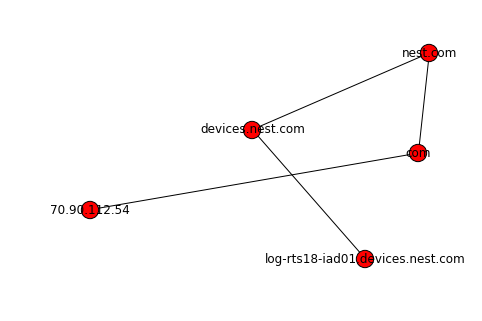

Total nodes: 5 Total edges:  4 Out degree at depth 1:  1
contains nest.com?  True


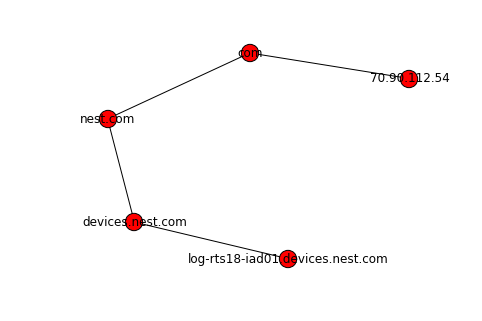

Total nodes: 5 Total edges:  4 Out degree at depth 1:  1
contains nest.com?  True


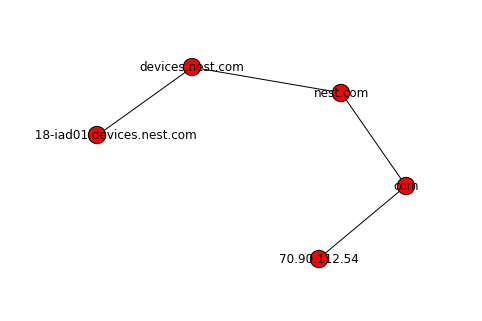

Total nodes: 13 Total edges:  12 Out degree at depth 1:  2
contains nest.com?  False


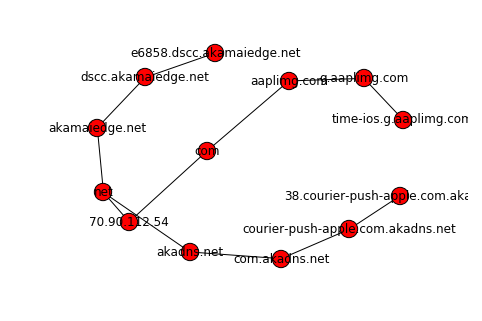



4 IP:  67.190.48.202 number of windows:  1
Total nodes: 9 Total edges:  8 Out degree at depth 1:  1
contains nest.com?  True


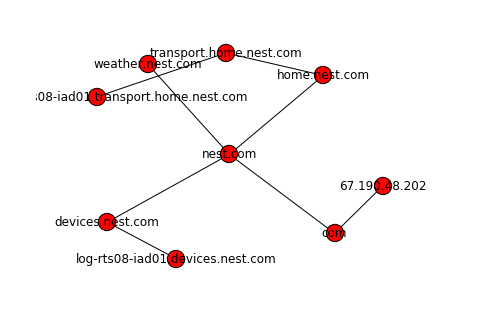



5 IP:  69.241.95.82 number of windows:  12
Total nodes: 4056 Total edges:  4055 Out degree at depth 1:  109
contains nest.com?  True
Total nodes: 4391 Total edges:  4390 Out degree at depth 1:  91
contains nest.com?  True
Total nodes: 4459 Total edges:  4458 Out degree at depth 1:  92
contains nest.com?  True
Total nodes: 4161 Total edges:  4160 Out degree at depth 1:  92
contains nest.com?  True
Total nodes: 4455 Total edges:  4454 Out degree at depth 1:  114
contains nest.com?  True
Total nodes: 4380 Total edges:  4379 Out degree at depth 1:  111
contains nest.com?  True
Total nodes: 4472 Total edges:  4471 Out degree at depth 1:  104
contains nest.com?  True
Total nodes: 4190 Total edges:  4189 Out degree at depth 1:  103
contains nest.com?  True
Total nodes: 4303 Total edges:  4302 Out degree at depth 1:  98
contains nest.com?  True
Total nodes: 4359 Total edges:  4358 Out degree at depth 1:  107
contains nest.com?  True
Total nodes: 4403 Total edges:  4402 Out degree at depth 1:

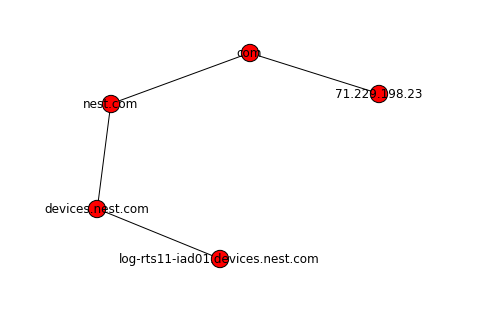

Total nodes: 12 Total edges:  11 Out degree at depth 1:  2
contains nest.com?  False


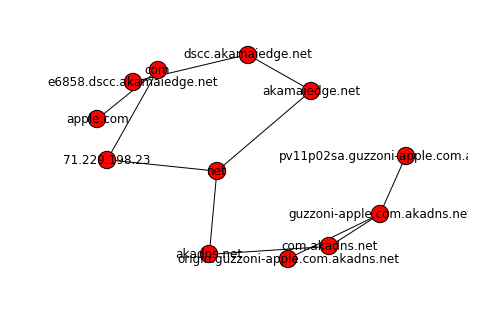



10 IP:  71.229.148.200 number of windows:  1
Total nodes: 4 Total edges:  3 Out degree at depth 1:  1
contains nest.com?  True


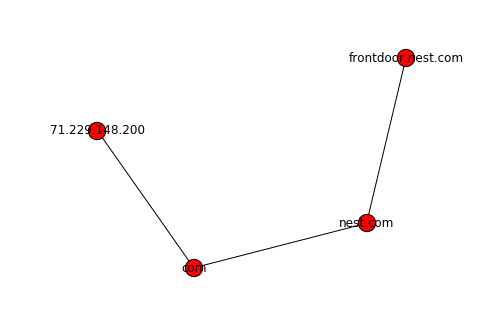

In [32]:
# print srcip, num of nodes, num of edges, degree (depth 1 children) and its tree
# don't draw if number of edges > 30
ctr=0
for srcip, list_of_trees in  nest_window.iteritems():
    ctr+=1
    print "\n\n", ctr, "IP: ", srcip, "number of windows: ", len(list_of_trees)
    for tree in list_of_trees:
        print "Total nodes:", tree.number_of_nodes(), "Total edges: ", tree.number_of_edges(), "Out degree at depth 1: ", tree.degree(srcip)
        print "contains nest.com? ", tree.has_node('nest.com')
        if tree.number_of_edges() < 30:
            draw_domain_tree(tree)

# Negative space algorithm for reducing tree to IoT related only

# TEST

In [ ]:
#T = nx.dfs_tree(G, 'A')
G2 = nx.Graph(nx.prim_mst_edges(G))
T = nx.bfs_tree(G2, 'A')
#T = nx.minimum_spanning_tree(G)

plt.figure()
#nx.draw(G, with_labels=True)
nx.draw(T, with_labels=True)
plt.show()

In [ ]:
G.has_node('A')

In [ ]:
x = '123.112.111.111'
t = x.find('.')
node = x[:t]
print node
x2 = x[t+1:]
t = x2.find('.')
print x2[:t]
print x2[t+1:]

In [ ]:
btree = nx.balanced_tree(2,4)
pos=nx.drawing.nx_agraph.graphviz_layout(btree,prog='dot')
nx.draw(btree,pos,with_labels=False,arrows=False)

In [ ]:
import networkx as nx

g=nx.DiGraph()
g.add_edges_from([(1,2), (1,3), (1,4), (2,5), (2,6), (2,7), (3,8), (3,9),
                  (4,10), (5,11), (5,12), (6,13)])
nx.drawing.nx_pydot.to_pydot(g)

In [ ]:
G = nx.Graph()



plt.figure()
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
G = nx.Graph()
G.add_node('A')
G.add_node('B')
G.add_node('C')
G.add_node('D')
G.add_node('E')
G.add_node('F')
G.add_node('G')
G.add_node('H')
G.add_node('I')
G.add_node('J')
G.add_node('K')

G.add_edge('A', 'B')
G.add_edge('A', 'C')
G.add_edge('A', 'D')
G.add_edge('B', 'E')
G.add_edge('B', 'F')
G.add_edge('C', 'G')
G.add_edge('D', 'H')
G.add_edge('D', 'I')
G.add_edge('D', 'J')
G.add_edge('I', 'K')

T = nx.depth_first_search.dfs_tree(G, 'A')
#T = nx.minimum_spanning_tree(G)

plt.figure()
nx.draw(G, with_labels=True)
#nx.draw(T, with_labels=True)
plt.show()